In [41]:
import math

import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from teleconnections.tc_class import Teleconnection
from teleconnections.plots import index_plot
from aqua.slurm import slurm

In [36]:
model1 = 'IFS'
exp1 = 'tco2559-ng5-cycle3'
source1 = 'lra-r100-monthly'

model2 = 'IFS'
exp2 = 'tco1279-orca025-cycle3'
source2 = '2D_monthly_native'

models = [model1, model2, model1]
exps = [exp1, exp2, exp1]
sources = [source1, source2, source1]

In [3]:
slurm.job()

2023-07-05 11:25:49 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-07-05 11:25:49 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-07-05 11:25:49 :: create_folder :: WARNING  -> Folder ./slurm/output already exists


2023-07-05 11:25:58 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 02:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382289/mambaforge/envs/teleconnections/bin/python -m distributed.cli.dask_worker tcp://136.172.124.4:42007 --nthreads 1 --memory-limit 9.31GiB --name dummy-name --nanny --death-timeout 60



In [9]:
telecname = 'NAO'
telec1 = Teleconnection(model=model1, exp=exp1, source=source1, telecname=telecname)
telec2 = Teleconnection(model=model2, exp=exp2, source=source2, telecname=telecname, regrid='r100')

In [10]:
telec1.evaluate_index()
telec2.evaluate_index()

2023-07-05 11:40:49 :: Teleconnection :: WARNING  -> No retrieve has been performed, trying to retrieve
2023-07-05 11:41:22 :: Teleconnection :: WARNING  -> No retrieve has been performed, trying to retrieve


In [11]:
telec1.evaluate_regression()
telec2.evaluate_regression()

In [37]:
regs = [telec1.regression, telec2.regression, telec1.regression]

In [12]:
def plot_box(num_plots=0):
    """
    Evaluate the number of rows and columns for a plot
    based on the number of plots to be plotted.

    Args:
        num_plots (int): Number of plots to be plotted.
    
    Returns:
        num_rows (int): Number of rows for the plot.
        num_cols (int): Number of columns for the plot.
    """

    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    return num_rows, num_cols

new max:  210.21580123673468
new min:  251.62875154733877
new max:  489.77814177343447
new min:  251.62875154733877
Final results:
max:  489.77814177343447
min:  251.62875154733877
step:  7.461451686199028
0 IFS
1 IFS
2 IFS


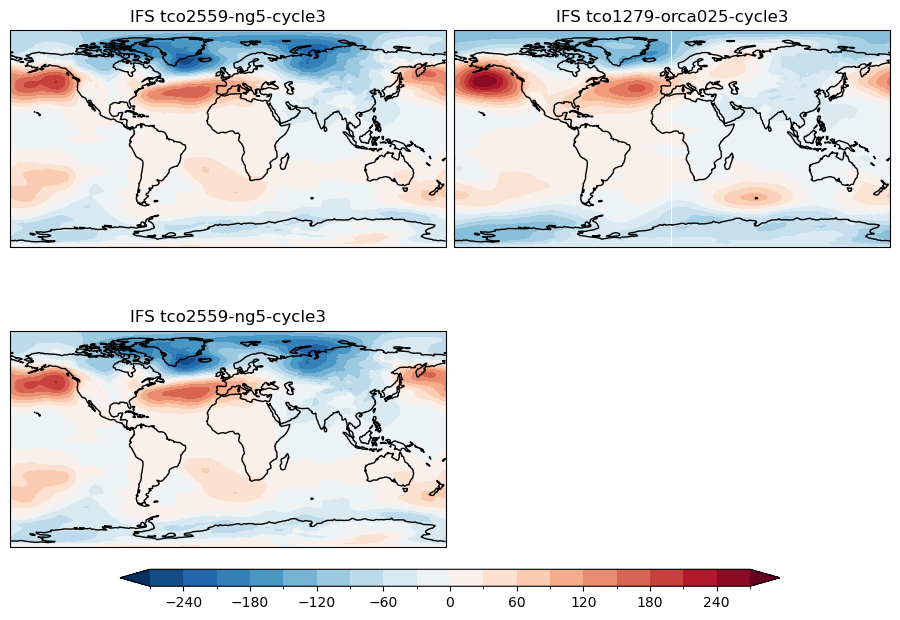

In [56]:
# Define the figure and each axis for the 3 rows and 3 columns
nrows, ncols = plot_box(num_plots=3)

fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

vmax = 0
vmin = 10000
for i in range(len(axs)):
        if i < len(models):
                maxval = regs[i].values.max()
                minval = regs[i].values.min()

                # Check if it's the absolute maximum or minimum
                if abs(maxval) > vmax:
                        vmax = abs(maxval)
                        print('new max: ', vmax)
                if abs(minval) < min:
                        vmin = abs(minval)
                        print('new min: ', vmin)
        else:
                # Hide unused subplots
                axs[i].axis('off')
print('Final results:')
print('max: ', vmax)
print('min: ', vmin)

# create common levels for all plots
nlevs = 21
step = (max-min)/nlevs
print('step: ', step)
clevs = np.arange(min,max,step)
#clevs = np.arange(-1,1.1,0.1)

#Loop over all of the models
for i,model in enumerate(models):
        print(i, model)
        # Select the week 1 forecast from the specified model
        data=regs[i]
        exp = exps[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=data['lon'])

        # Contour plot
        cs = regs[i].plot.contourf(ax=axs[i], transform=ccrs.PlateCarree(),
                                   cmap='RdBu_r', levels=nlevs, add_colorbar=False,
                                   add_labels=False, extend='both')#, vmin=vmin, vmax=vmax)
        #regs[i].contour()
        # cs=axs[i].contourf(lons,data['lat'],data,
        #                   transform = ccrs.PlateCarree(),
        #                   cmap='coolwarm',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(model+' '+exp)

        # Draw the coastines for each subplot
        axs[i].coastlines()

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

In [8]:
def index_multiple(indxs):

    num_plots = len(indxs)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols)

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.index_plot(indxs[i])
            ax.set_title(f'Plot {i+1}')
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()

In [ ]:
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for i,model in enumerate(models):

        # Select the week 1 forecast from the specified model
        data=ds[model][0,:,:]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,ds['lat'],data,
                          transform = ccrs.PlateCarree(),
                          cmap='coolwarm',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(model)

        # Draw the coastines for each subplot
        axs[i].coastlines()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [9]:
def comparison_regression_plot(regs=None, models=None, exps=None, **kwargs):
    """
    Comparison plot of the indices

    Args:
        regs (list):           list of regression maps
        models (list):         list of models
        exps (list):           list of experiments
        sources (list):        list of sources
        **kwargs:              additional arguments for set_layout
    """

    if regs is None:
        raise ValueError('regression is None')

    # 1. -- Generate the figure --

    # Set the layout of the figure
    num_plots = len(regs)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    # Create the figure with ratio 16:9
    fig, axes = plt.subplots(num_rows, num_cols)
    fig.set_size_inches(16, 9)

    # Set the titles
    # Main title
    try:
        fig.suptitle('Comparison of the {} regression maps'.format(telecname))
    except NameError:
        fig.suptitle('Comparison of regression maps')

    # Subtitles
    titles = []
    for i, model in enumerate(models):
        titles.append(f'{model} {exps[i]}')

    # 2. -- Plot the indices --
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            # # Cartopy projection
            # ax = plt.axes(projection=ccrs.PlateCarree())
            # ax.coastlines()

            # Plot the regression map
            regs[i].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
            ax.set_title(titles[i])
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    fig.tight_layout()

    return fig, ax

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

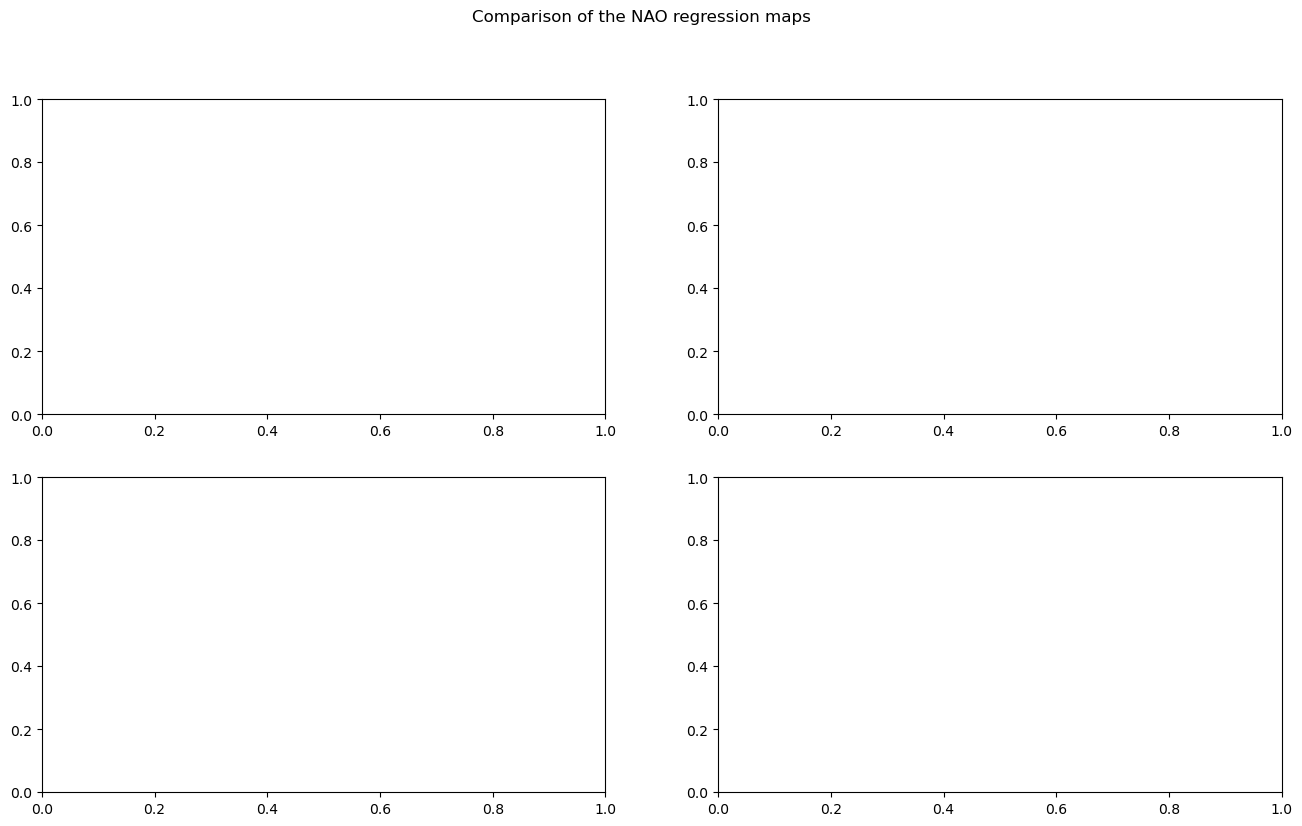

In [10]:
comparison_regression_plot(regs=[telec1.regression, telec2.regression, telec1.regression], models=[model1, model2, model1], exps=[exp1, exp2, exp1], telecname=telec1.telecname)

3


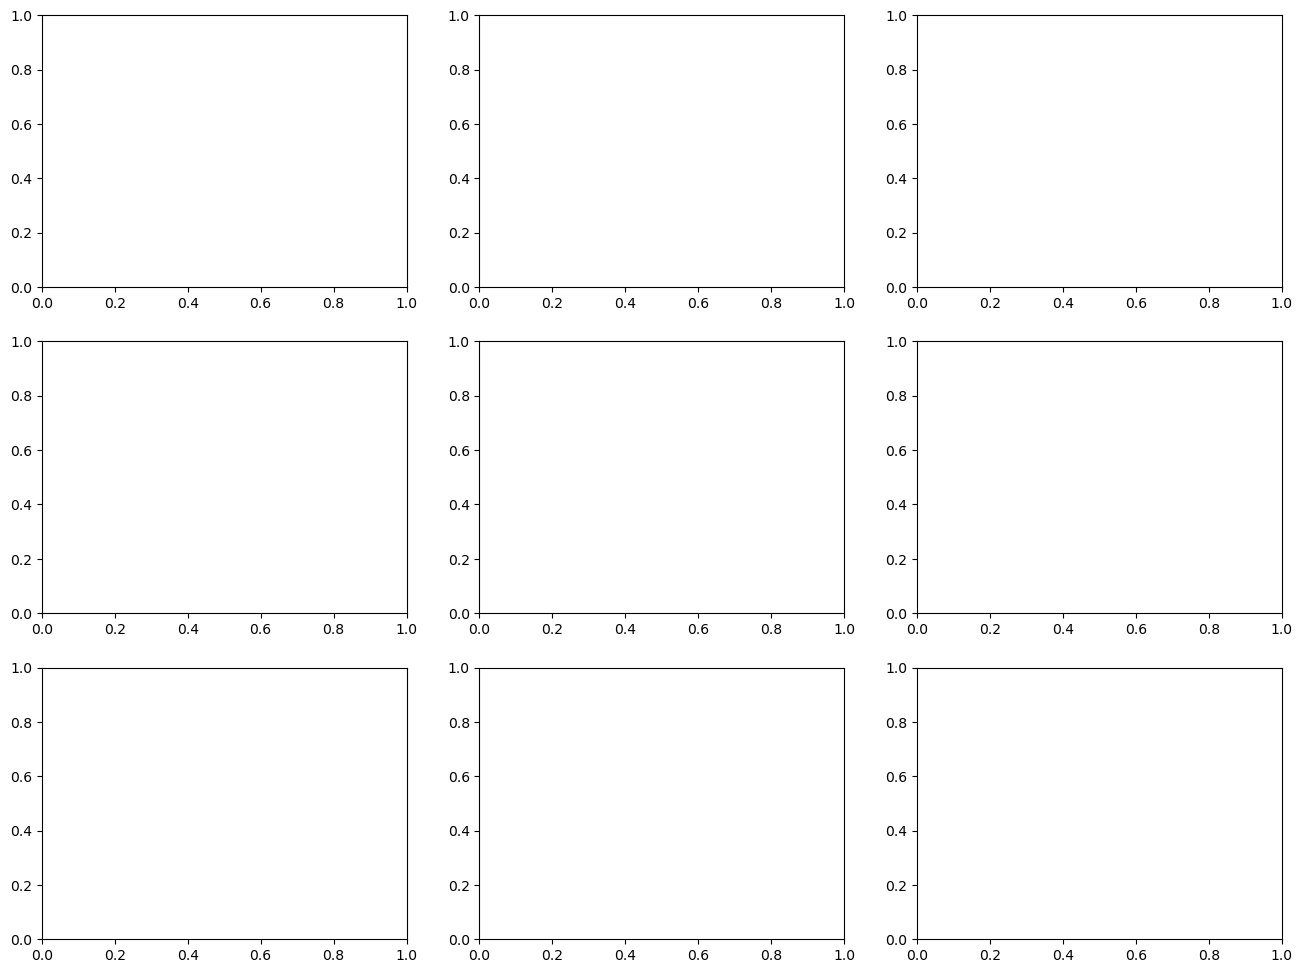

In [18]:
import numpy as np

sideSubPlot = int(np.ceil(np.sqrt(5)))
print(sideSubPlot)
fig, ax = plt.subplots(sideSubPlot, sideSubPlot, figsize = (16, 12))
        # fig, ax = plt.subplots(sideSubPlot, sideSubPlot, figsize = (16, 12))
        # for js, setup in enumerate(mySetups):
        #     label = " ".join([s for s in setup])
        #     for jr, region in enumerate(myRegions):

        #         extent = myExtents[js][jr]

        #         jx = jr // sideSubPlot
        #         jy = jr %  sideSubPlot


        #         ax[jx, jy].plot(extent.time, extent, label = label)

        #         ax[jx,jy].set_title("Sea ice extent: region " + region)

        #         ax[jx,jy].legend()
        #         ax[jx,jy].set_ylabel(extent.units)
        #         ax[jx,jy].grid()
        # fig.tight_layout()
        # for fmt in ["png", "pdf"]:
        #     fig.savefig("./figSIE." + fmt, dpi = 300)

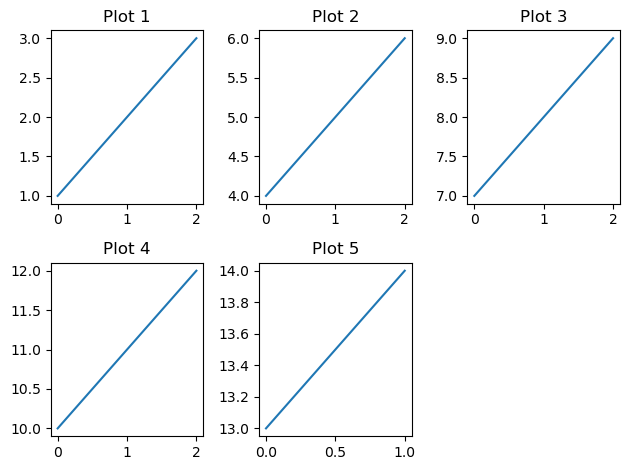

In [21]:
import matplotlib.pyplot as plt
import math

def plot_multiple(data, num_plots):
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols)

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.plot(data[i])
            ax.set_title(f'Plot {i+1}')
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()

# Example usage
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14]]
num_plots = len(data)

plot_multiple(data, num_plots)


In [8]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
5863180    256   1     R          dask-worker          13:38      2023-07-05T11:26:46  (null)               compute              10G                 


0

In [5]:
slurm.scancel(Job_ID=5862085)